#### Импортируем необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix

from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from surprise import accuracy
from surprise.model_selection import GridSearchCV

ModuleNotFoundError: No module named 'pandas'

## 1. Знакомство с данными и EDA

#### Загрузка данных

In [10]:
# ratings.csv, books.csv, tags.csv, book_tags.csv.
df_ratings = pd.read_csv('./ratings.csv')
df_books = pd.read_csv('./books.csv')
df_tags = pd.read_csv('./tags.csv')
df_book_tags = pd.read_csv('./book_tags.csv')

#### Определим структуру и посмотрим на данные

In [11]:
print(df_ratings.info())
df_ratings.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981756 entries, 0 to 981755
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   book_id  981756 non-null  int64
 1   user_id  981756 non-null  int64
 2   rating   981756 non-null  int64
dtypes: int64(3)
memory usage: 22.5 MB
None


,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4


In [12]:
print(df_books.info())
df_books.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         10000 non-null  int64  
 1   book_id                    10000 non-null  int64  
 2   best_book_id               10000 non-null  int64  
 3   work_id                    10000 non-null  int64  
 4   books_count                10000 non-null  int64  
 5   isbn                       9300 non-null   object 
 6   isbn13                     9415 non-null   float64
 7   authors                    10000 non-null  object 
 8   original_publication_year  9979 non-null   float64
 9   original_title             9415 non-null   object 
 10  title                      10000 non-null  object 
 11  language_code              8916 non-null   object 
 12  average_rating             10000 non-null  float64
 13  ratings_count              10000 non-null  int6

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


In [13]:
print(df_tags.info())
df_tags.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34252 entries, 0 to 34251
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tag_id    34252 non-null  int64 
 1   tag_name  34252 non-null  object
dtypes: int64(1), object(1)
memory usage: 535.3+ KB
None


,tag_id,tag_name
0,0,-
1,1,--1-
2,2,--10-
3,3,--12-
4,4,--122-


In [14]:
print(df_book_tags.info())
df_book_tags.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999912 entries, 0 to 999911
Data columns (total 3 columns):
 #   Column             Non-Null Count   Dtype
---  ------             --------------   -----
 0   goodreads_book_id  999912 non-null  int64
 1   tag_id             999912 non-null  int64
 2   count              999912 non-null  int64
dtypes: int64(3)
memory usage: 22.9 MB
None


,goodreads_book_id,tag_id,count
0,1,30574,167697
1,1,11305,37174
2,1,11557,34173
3,1,8717,12986
4,1,33114,12716


### Разведочный анализ

#### Распределение оценок

In [15]:
# Проверим рейтинг на наличие дубликатов
df_ratings[df_ratings.duplicated(subset=['user_id', 'book_id'], keep=False)].count()

book_id    4487
user_id    4487
rating     4487
dtype: int64

In [16]:
# Выборочно посмотрим на дубликаты
df_ratings[df_ratings.duplicated(subset=['user_id', 'book_id'], keep=False)].head(10)

,book_id,user_id,rating
1170,12,40251,4
1171,12,40251,4
2473,25,32635,5
2474,25,32635,5
2717,28,9011,2
2718,28,9011,1
2946,30,24582,4
2947,30,24582,3
2958,30,31760,4
2959,30,31760,4


In [17]:
# В данных видно, что данные не просто логически дублируются, а содержат дубли по ключам
# Так как мы не имеем привязки оценок ко времени, остается только произвести агрегацию таких записей
df_ratings = df_ratings.groupby(['user_id', 'book_id'])['rating'].mean().reset_index()

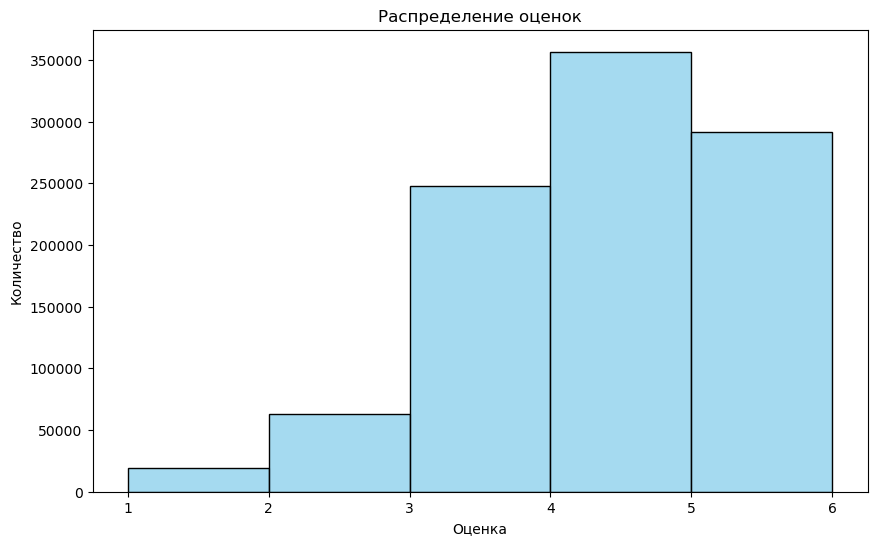

Средняя оценка: 3.86


In [18]:
# Создаем гистограмму рапсределения оценок
plt.figure(figsize=(10, 6))
sns.histplot(data=df_ratings, x='rating', bins=range(1, 7), kde=False, color='skyblue')
plt.title('Распределение оценок')
plt.xlabel('Оценка')
plt.ylabel('Количество')
plt.show()

# Рассчитаем среднюю оценку
mean_rating = df_ratings['rating'].mean()
print(f"Средняя оценка: {mean_rating:.2f}")

Судя по гистограмме распеределения оценок, можно отметить наличие сдвига в сторону высоких значений.  
Большинство пользователей склонны ставить высокие оценки, необходимо учитывать это при дальнейшем анализе и разработке рекомендаций.

#### Анализ активности пользователей

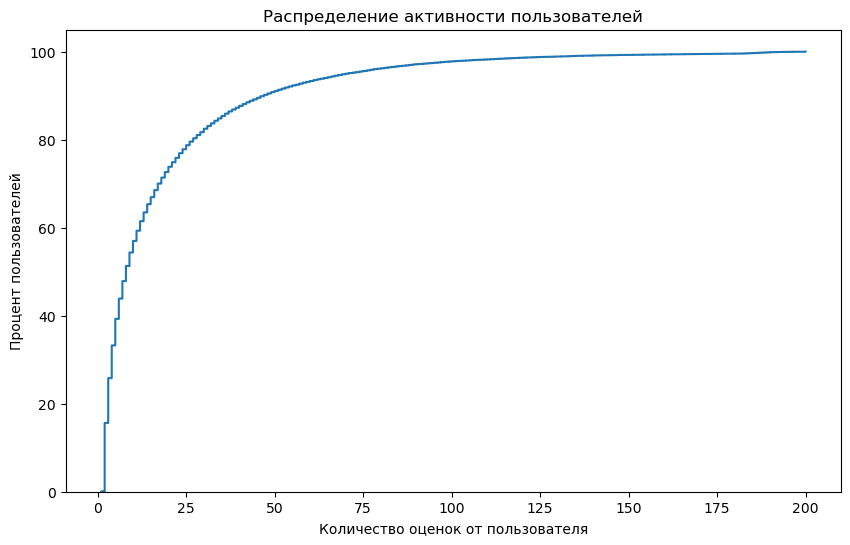

Количество пользователей с наибольшей активностью (более 100 оценок): 1194 (2.235%)
Пользователь с наибольшей активностью: ID=12874, Количество оценок=200

Количество пользователей с наименьшей активностью (не более 5 оценок): 20985 (39.280%)
Пользователь с наименьшей активностью: ID=47004, Количество оценок=1


In [19]:
# Подсчитаем количество оценок для каждого пользователя
user_activity = df_ratings.groupby('user_id')['rating'].count().reset_index(name='num_ratings')

# Построим график распределения активности пользователей
plt.figure(figsize=(10, 6))
sns.ecdfplot(user_activity['num_ratings'], stat='percent')
plt.title('Распределение активности пользователей')
plt.xlabel('Количество оценок от пользователя')
plt.ylabel('Процент пользователей')
plt.show()

# Найдем наиболее и наименее активных пользователей
count_users = user_activity['user_id'].nunique()
most_active_users = user_activity.where(user_activity['num_ratings'] >= 100).groupby('num_ratings')['user_id'].count().sum()
most_active_percent = 100 / count_users * most_active_users
most_active_user = user_activity.sort_values(by='num_ratings', ascending=False).iloc[0]
least_active_users = user_activity.where(user_activity['num_ratings'] <= 5).groupby('num_ratings')['user_id'].count().sum()
least_active_percent = 100 / count_users * least_active_users
least_active_user = user_activity.sort_values(by='num_ratings').iloc[0]

print(f'Количество пользователей с наибольшей активностью (более 100 оценок): {most_active_users} ({most_active_percent:.3f}%)')
print(f'Пользователь с наибольшей активностью: ID={most_active_user.user_id}, Количество оценок={most_active_user.num_ratings}')
print()
print(f'Количество пользователей с наименьшей активностью (не более 5 оценок): {least_active_users} ({least_active_percent:.3f}%)')
print(f'Пользователь с наименьшей активностью: ID={least_active_user.user_id}, Количество оценок={least_active_user.num_ratings}')

На графике видно, что большое количество пользователей (порядка 40%) имеет малое число выставленных оценок (не более 5), что создает проблему "холодного старта".  
В то же время, абсолютное большинство пользователей (порядка 80%) имеют не более 25 оценок. Активные пользователи помогают сформировать матрицу предпочтений, однако недостаточная активность большинства пользователей может усложнит создание качественных рекомендаций.  
Необходимо учитывать, что пользователи с большой активностью, могут вносить "перекос" в систему рекомендаций.

#### Анализ популярности книг

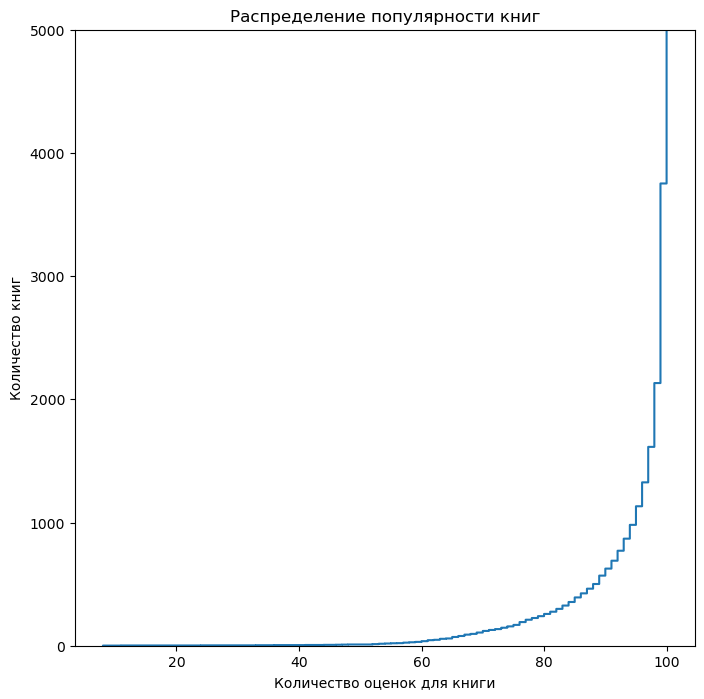

Книги с большим количеством оценок: 6248 (62.480)%
Книги с малым количеством оценок: 3752 (37.520)%


In [20]:
# Найдем количество оценок для каждой книги
book_popularity = df_ratings.groupby('book_id')['rating'].count().reset_index(name='num_ratings')

# Построим график распределения популярности книг
plt.figure(figsize=(8, 8))
sns.ecdfplot(book_popularity['num_ratings'], stat='count').set_ylim([0,5000])
plt.title('Распределение популярности книг')
plt.xlabel("Количество оценок для книги")
plt.ylabel('Количество книг')
plt.show()

# Посчитаем распределение популярных и непопулярных книг
count_books = book_popularity['book_id'].nunique()
most_popular_books = book_popularity.where(book_popularity['num_ratings'] >= 100).groupby('num_ratings')['book_id'].count().sum()
least_popular_books = book_popularity.where(book_popularity['num_ratings'] < 100).groupby('num_ratings')['book_id'].count().sum()

print(f"Книги с большим количеством оценок: {most_popular_books} ({100 / count_books * most_popular_books:.3f})%")
print(f"Книги с малым количеством оценок: {least_popular_books} ({100 / count_books * least_popular_books:.3f})%")

На графике можно увидеть значительное преобладание популярных книг.  
Неоцененные книги могут остаться практически неизвестными для пользователей, именно в этом выражается проблема "длинного хвоста".  
Такая неравномерность в распределении может затруднять рекомендацию новых произведений и вызывать замкнутый круг, когда неизвестные произведения не будут рекомендоваться, т.к. у них нет оценок.

   tag_id      count           tag_name
9   22743    1224279              owned
8   26138    1231926            romance
7    5207    1317235        books-i-own
6    7457    1756920           classics
5   33114    1848306        young-adult
4   11305    3548157            fantasy
3   11743    3688819            fiction
2   11557    4503173          favorites
1    8717    7507958  currently-reading
0   30574  140718761            to-read


C:\Users\BMakunin\AppData\Local\Temp\ipykernel_28312\2593969968.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='tag_name', y='count', data=top_10_tags_name, orient='v', palette='viridis')


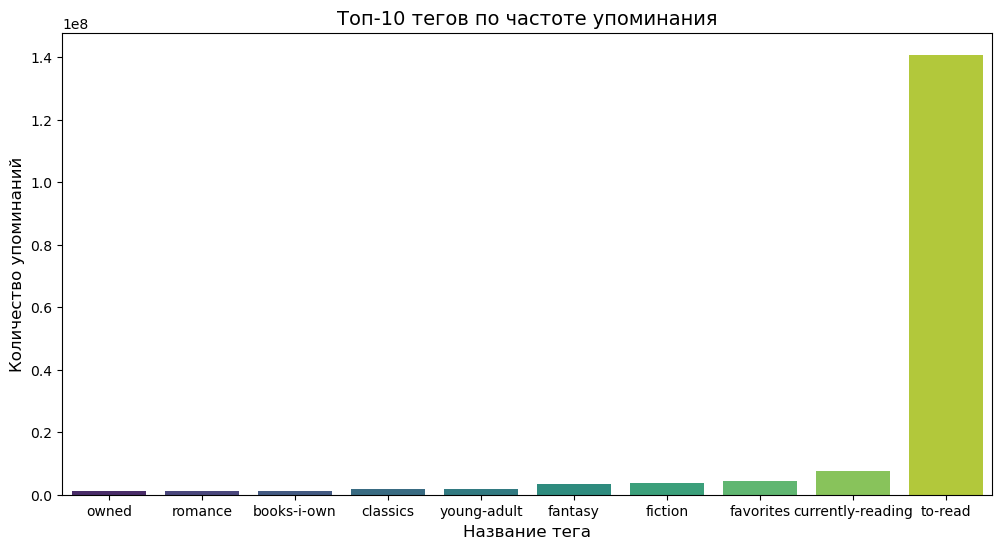

In [21]:
# Отсортируем теги по частоте упоминания
top_10_tags = df_book_tags.drop('goodreads_book_id',axis=1).groupby('tag_id').sum('count').reset_index() \
    .sort_values(by='count', ascending=False).head(10)

# Найдем названия тегов по справочнику
top_10_tags_name = pd.merge(top_10_tags, df_tags, on='tag_id', how='inner').sort_values(by='count', ascending=True)
print(top_10_tags_name)

# Покажем топ-10 тегов по частоте упоминания
plt.figure(figsize=(12, 6))
sns.barplot(x='tag_name', y='count', data=top_10_tags_name, orient='v', palette='viridis')
plt.title('Топ-10 тегов по частоте упоминания', fontsize=14)
plt.ylabel('Количество упоминаний', fontsize=12)
plt.xlabel('Название тега', fontsize=12)
plt.show()

### Выводы на основе EDA

На основе проведенного анализа можно выделить несколько возможных проблем, которые необходимо будет учитывать в дальнейшей работе, и путей их решения.
1. Разреженность данных. Основная масса оценок выставлена лишь небольшим процентом активных пользователей, что создаёт проблему низкой плотности данных. Для решения этой проблемы можно попробовать объединить пользователей в кластеры (по интересам, возрасту и т.д.), либо же примененять методы заполнения пропусков.
2. Смещение популярности. Некоторые книги имеют очень низкую популярность и редко получают оценки, что также может сказаться на точности рекомендаций. Для решения этой проблемы можно попробовать искуственно увеличить процент рекомендаций неоцененных книг.
3. Проблема "холодного старта". Новые пользователи, поставившие мало оценок, или недавно вышедшие книги, еще не получившие оценок, сложно включить в модель рекомендаций, поскольку имеется недостаточное количество данных для их формирования. Решением этой проблемы может стать "усреднение" нового пользователя с постепенныи формированием профиля, по мере получения оценок или проведения опросов. Для книг же, как и со смещением популярности, рекомендуется "подмешивать" малооцененные книги в рекомендации.

## 2. Реализиция базовой и контентной модели.

#### Базовая неперсонализированная модель  
Реализуем алгоритм, возвращающий Top-10 самых популярных книг (по среднему рейтингу с порогом минимального количества оценок).

In [22]:
# Найдем названия тегов по справочнику
base_book_tags = pd.merge(df_book_tags, df_tags, on='tag_id', how='left')
base_book_tags = base_book_tags.groupby('goodreads_book_id')['tag_name'].apply(list).reset_index()

# Соединим теги и книги
base_books = pd.merge(df_books, base_book_tags, left_on='book_id', right_on='goodreads_book_id', how='left')

# Рассчитаем средний рейтинг и количество оценок
base_book_ratings = df_ratings.groupby('book_id').agg({'rating': ['mean', 'count']}).reset_index()
base_book_ratings.columns = ['book_id', 'avg_rating', 'num_ratings']

# Объединим данные о книгах и рейтинг
base_books = pd.merge(base_books, base_book_ratings, on='book_id', how='left')

# Отфильтруем книги с малым количеством оценок
base_filtered_books = base_books[base_books['num_ratings'] >= 50]

# Отбираем топ-10 книг
base_top_books = base_filtered_books.sort_values(by='avg_rating', ascending=False).head(10)

print("Топ-10 самых популярных книг:")
base_top_books[['book_id', 'original_title', 'avg_rating', 'num_ratings']]

Топ-10 самых популярных книг:


,book_id,original_title,avg_rating,num_ratings
1298,9566,Still Life with Woodpecker,4.777778,99.0
3254,4708,The Beautiful and Damned,4.660000,100.0
4871,9569,Villa Incognito,4.625000,96.0
3909,9531,Peter and the Shadow Thieves,4.557143,70.0
6662,3885,The Taste of Home Cookbook,4.550000,100.0
662,2767,A People's History of the United States: 1492 ...,4.540000,100.0
2845,5344,Hard Times: For These Times,4.535354,99.0
147,2865,Girl with a Pearl Earring,4.530000,100.0
144,976,Deception Point,4.500000,100.0
3140,6862,Amsterdam,4.494737,95.0


#### Контентная модель
Находит самые похожие книги по косинусной мере близости между их TF-IDF-векторами.

In [23]:
# Найдем названия тегов по справочнику
cont_book_tags = pd.merge(df_book_tags, df_tags, on='tag_id', how='left')
cont_book_tags = cont_book_tags.groupby('goodreads_book_id')['tag_name'].apply(lambda x: sorted(x)).reset_index()

# Соединим теги и книги
cont_books = pd.merge(df_books, cont_book_tags, left_on='book_id', right_on='goodreads_book_id', how='left')

# Создадим текстовый профиль для каждой книги
cont_books['profile'] = cont_books['original_title'] + ' ' + cont_books['tag_name'].astype(str)

# Векторизуем текстовые проифли с помощью TF-IDF
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(cont_books['profile'].fillna('unknown'))

# Создадим функцию для поиска похожих книг по косинусной мере близости между TF-IDF векторами
def get_similar_books(book_id, N=5):
    """
    Функция для поиска похожих книг по косинусной мере близости между TF-IDF векторами
    """
    # Находим индекс книги
    if book_id not in set(cont_books['book_id']):
        return 'Нет книги с таким ID'
    else: idx = cont_books[cont_books['book_id'] == book_id].index[0]
    
    # Вычисляем косинусную близость
    similarity_scores = cosine_similarity(tfidf_matrix[idx], tfidf_matrix).flatten()
    
    # Получаем индексы N самых похожих книг
    similar_indices = similarity_scores.argsort()[-N-1:-1][::-1]
    
    # Возвращаем названия N самых похожих книг
    return cont_books.iloc[similar_indices]['original_title'].values

In [24]:
# book_id = 73070
# book_id = 4
book_id = 1
if book_id in set(cont_books['book_id']):
    orig_name = cont_books[cont_books['book_id'] == book_id].original_title.item()
    print(f'Похожие книги для книги {orig_name} с ID', book_id, ':')

similar_books = get_similar_books(book_id)
print(similar_books)

Похожие книги для книги Harry Potter and the Half-Blood Prince с ID 1 :
['Harry Potter and the Deathly Hallows'
 'Harry Potter and the Chamber of Secrets'
 "Harry Potter and the Philosopher's Stone"
 'Harry Potter and the Goblet of Fire'
 'Harry Potter and the Prisoner of Azkaban']


## 3. Коллаборативная фильтрация (Item-Based CF)

In [334]:
# Построим матрицу взаимодействий user_x_book, заполнив пропущенные значения нулями
user_book_matrix = df_ratings.pivot(index='user_id', columns='book_id', values='rating').fillna(0)

# Мы помним, что большее количество пользователей ставят малое количество оценок (разреженная матрица)
# В таком случае имеет смысл преобразовать матрицу в формат CSR, для более эффективного использования памяти и ускорения вычислений
sparse_matrix = csr_matrix(user_book_matrix.values)

In [335]:
# Рассчитаем матрицу попарных схожестей между книгами по косинусной близости по векторам оценок
item_similarity = cosine_similarity(sparse_matrix.T)

In [362]:
# Создадим функцию для предсказания оценки по заданной книге и пользователю
def predict_rating(user_id, book_id, K=5):
    # Найдем индексы книг, которые пользователь уже оценил
    user_ratings = user_book_matrix.loc[user_id]
    rated_books = user_ratings[user_ratings > 0].index
    
    # Найдем наиболее похожие книги для заданной
    similar_books = []
    for rated_book in rated_books:
        similarity_scores = item_similarity[user_book_matrix.columns.get_loc(book_id)]
        similar_books.append((rated_book, similarity_scores[user_book_matrix.columns.get_loc(rated_book)]))
    
    similar_books.sort(key=lambda x: x[1], reverse=True)
    similar_books = similar_books[:K]
    
    # Вычислим предсказание оценки, поделив сумму произведений оценок пользователя на схожесть между книгами на сумму схожестей между книгами
    numerator = sum(user_ratings[rated_book] * similarity for rated_book, similarity in similar_books)
    denominator = sum(similarity for i, similarity in similar_books)
    
    if denominator == 0:
        return 0
    else:
        return numerator / denominator

In [342]:
user_id = 314
book_id = 2
predicted_rating = predict_rating(user_id, book_id)
print(f'Предсказанная оценка для пользователя {user_id} и книги {book_id}: {predicted_rating}')

Предсказанная оценка для пользователя 314 и книги 2: 4.287052523558288


Вычислительная сложность данного подхода заключается в расчете матрицы попарных схожестей между книгами, для которой $O(n^2)$, где n - количество книг.
Для оптимизации этих рассчетов можно применить следующие методы:  
1. Использование разреженного формата представления данных (что и было применено, иначе предсказание считалось довольно долго), позволяющее сократить объем потребляемой памяти и ускорить вычисления.
2. Аппроксимировать матрицу схожестей (например с помощью методов SVD или ALS), для уменьшения её размерности.
3. Использовать параллелизацию.

## 4. Матричные разложения (MF)

Реализуем более продвинутые и масштабируемые методы предсказания оценок.

In [30]:
# Загрузим данные в формат, подходящий для scikit-surprise
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df_ratings[['user_id', 'book_id', 'rating']], reader)

In [48]:
# Разделим данныу на обучающую и тестовую выборки
trainset, testset = train_test_split(data, test_size=0.25)

In [49]:
# Обучим модель SVD
model = SVD()
model.fit(trainset)

In [53]:
# Выполним предсказание оценок на тестовой выборе
predictions = model.test(testset)

In [54]:
# Рассчитаем среднеквадратичную ошибку (RSME)
rmse = accuracy.rmse(predictions)

RMSE: 0.8485


In [ ]:
# Получилось достаточно большое значение RSME, попробуем подобрать гиперпараметры
param_grid = {'n_factors': [50, 100, 150], 'reg_all': [0.02, 0.05, 0.1]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3)
gs.fit(data)

In [66]:
print(gs.best_params['rmse'])

{'n_factors': 50, 'reg_all': 0.1}


In [67]:
# Обучим модель SVD с подобранными гиперпараметрами
model = SVD(n_factors=50, reg_all=0.1)
model.fit(trainset)

In [68]:
# Выполним предсказание оценок на тестовой выборе
predictions = model.test(testset)
# Рассчитаем среднеквадратичную ошибку (RSME)
rmse = accuracy.rmse(predictions)

RMSE: 0.8420


Значение среднеквадратичной ошибки ~0.8 означает, что в среднем модель ошибается на 0.8 балла из 5 (16%).  
Принимаем его, пусть и хотелось бы иметь меньшее отклонение.  
Возможно для более точных предсказаний нужно получить больше оценок от пользователей, что позволит лучше обучить модель.

In [69]:
# Создадим функцию, которая для заданного пользователя возвращает топ-N книг с наибольшим предсказанным рейтингом
def get_recommendations(user_id, N=5):
    # Получим множество книг, которые пользователь еще не оценил
    user_items = set(trainset.to_raw_iid(i) for i in trainset.all_items())
    user_rated_items = set((trainset.to_raw_iid(iid) for (uid, iid, _) in trainset.all_ratings() if trainset.to_raw_uid(uid) == user_id))
    items_to_predict = user_items - user_rated_items

    # Выполним предсказание для всех книг и отсортируем их в порядке убывания оценки
    predictions = [model.predict(user_id, item) for item in items_to_predict]
    predictions.sort(key=lambda x: x.est, reverse=True)

    # Возвращаем топ-N книг
    return [pred.iid for pred in predictions[:N]]

In [71]:
user_id = 314
recommendations = get_recommendations(user_id)
print(f"Рекомендации для пользователя {user_id}: {recommendations}")

Рекомендации для пользователя 314: [862, 5207, 4868, 6920, 6590]


## 5. Оценка и сравнение моделей

In [592]:
# Создадим словарь для хранения данных для сводной таблицы результатов
results = {}
results['popularity_recommendations (full)'] = {}
results['Item-Based CF (0.001)'] = {}
results['SVD (0.01)'] = {}

In [653]:
# Создаем функцию для расчета Precision@K
def precision_at_k(recommendations, actual_ratings, k=5, threshold=4):
    # Получаем первые K рекомендаций
    top_k_recommendations = recommendations[:k]
    
    # Получаем релевантные книги (оценка ≥ threshold)
    relevant_books = set(actual_ratings[actual_ratings['rating'] >= threshold]['book_id'])
    
    # Подсчитываем количество релевантных рекомендаций среди первых K
    n_rel_and_rec_k = sum(1 for book in top_k_recommendations if book in relevant_books)
    
    # Рассчитываем Precision@K
    precision = n_rel_and_rec_k / k if k > 0 else 0
    
    return precision

In [651]:
# Создаем функцию для расчета Recall@K
def recall_at_k(recommendations, actual_ratings, k=5, threshold=4):
    # Получаем первые K рекомендаций
    top_k_recommendations = recommendations[:k]
    
    # Получаем релевантные книги (оценка ≥ threshold)
    relevant_books = set(actual_ratings[actual_ratings['rating'] >= threshold]['book_id'])
    
    # Подсчитываем количество релевантных рекомендаций среди первых K
    n_rel_and_rec_k = sum(1 for book in top_k_recommendations if book in relevant_books)
    
    # Рассчитываем Recall@K
    recall = n_rel_and_rec_k / len(relevant_books) if len(relevant_books) > 0 else 0
    
    return recall

In [652]:
# Создаем функцию для расчета nDCG@K
def ndcg_at_k(recommendations, actual_ratings, k=5):
    # Получаем первые K рекомендаций
    top_k_recommendations = recommendations[:k]
    
    # Получаем фактические оценки для рекомендованных книг
    actual_ratings_dict = actual_ratings.set_index('book_id')['rating'].to_dict()
    
    # Рассчитываем DCG и IDCG
    dcg = 0
    idcg = 0
    for i, book_id in enumerate(top_k_recommendations):
        if book_id in actual_ratings_dict:
            relevance = actual_ratings_dict[book_id]
            dcg += (2 ** relevance - 1) / np.log2(i + 2)
        idcg += (2 ** 5 - 1) / np.log2(i + 2)
    
    # Рассчитываем nDCG@K
    ndcg = dcg / idcg if idcg != 0 else 0
    
    return ndcg

## Popularity

In [631]:
# Подготовим данные для сравнения и разделим их на выборки
# При необходимости - уменьшаю количество данных, так как очень долго считает
# small_df_ratings = df_ratings.sample(frac=0.1)
small_df_ratings = df_ratings.sample(frac=1)
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(small_df_ratings[['user_id', 'book_id', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.25)
# Получаем все уникальные user_id
user_ids = small_df_ratings['user_id'].unique()

In [632]:
# Реализуем функцию выдачи топа популярных по количеству оценок книг
def popularity_recommendations(N=5):
    # Получаем топ-N самых популярных книг
    popular_books = small_df_ratings['book_id'].value_counts().index[:N]

    # Возвращаем топ-N книг
    return list(popular_books)

In [633]:
%%time
precisions = []
recalls = []
ndcgs = []
N = 5
k = 5

# Получаем рекомендации
recommendations = popularity_recommendations(N)


for user_id in user_ids:
    # Получаем фактические оценки пользователя
    actual_ratings = small_df_ratings[small_df_ratings['user_id'] == user_id]
    
    # Рассчитываем Precision@K
    precision = precision_at_k(recommendations, actual_ratings, k)
    precisions.append(precision)

    # Рассчитываем Recall@K
    recall = recall_at_k(recommendations, actual_ratings, k)
    recalls.append(recall)

    # Рассчитываем nDCG@K
    ndcg = ndcg_at_k(recommendations, actual_ratings, k)
    ndcgs.append(ndcg)

# Усредняем Precision@K по всем пользователям
average_precision = sum(precisions) / len(precisions)
print(f'Mean Average Precision (MAP) для модели Popularity: {average_precision:.4f}')

# Усредняем Recall@K по всем пользователям
average_recall = sum(recalls) / len(recalls)
print(f'Mean Average Recall для модели Popularity: {average_recall:.4f}')

# Усредняем nDCG@K по всем пользователям
average_ndcg = sum(ndcgs) / len(ndcgs)
print(f'Average nDCG для модели Popularity: {average_ndcg:.4f}')

Mean Average Precision (MAP) для модели Popularity: 0.0012
Mean Average Recall для модели Popularity: 0.0002
Average nDCG для модели Popularity: 0.0009
CPU times: total: 3min 37s
Wall time: 3min 48s


In [634]:
# Добавляем данные в сводную таблицу
results['popularity_recommendations (full)']['presicion@K'] = average_precision
results['popularity_recommendations (full)']['recall@K'] = average_recall
results['popularity_recommendations (full)']['nDCG@K'] = average_ndcg

Mean Average Precision (MAP) для модели Popularity: 0.0012  
CPU times: total: 2min  
Wall time: 2min 9s

Average Recall для модели Popularity: 0.0002
CPU times: total: 2min 3s
Wall time: 2min 9s

Average nDCG для модели Popularity: 0.0009
CPU times: total: 3min 37s
Wall time: 3min 48s

## Item-Based CF

Для модели Item-Based CF используем функцию predict_rating() на урезанном количестве данных.

In [627]:
# Подготовим данные для сравнения и разделим их на выборки
# Уменьшаю количество данных, так как очень долго считает
small_df_ratings = df_ratings.sample(frac=0.001)
# small_df_ratings = df_ratings.sample(frac=1)
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(small_df_ratings[['user_id', 'book_id', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.25)
# Получаем все уникальные user_id
user_ids = small_df_ratings['user_id'].unique()

In [628]:
# Построим матрицу взаимодействий user_x_book, заполнив пропущенные значения нулями
user_book_matrix = small_df_ratings.pivot(index='user_id', columns='book_id', values='rating').fillna(0)

# Мы помним, что большее количество пользователей ставят малое количество оценок (разреженная матрица)
# В таком случае имеет смысл преобразовать матрицу в формат CSR, для более эффективного использования памяти и ускорения вычислений
sparse_matrix = csr_matrix(user_book_matrix.values)
# Рассчитаем матрицу попарных схожестей между книгами по косинусной близости по векторам оценок
item_similarity = cosine_similarity(sparse_matrix.T)

Среднее время расчета для одного user_id при масштабе 1% (0.001) от исходного датафрейма (порядка 9000 оценок) - 4 секунды, даже при использовании разреженной матрицы.  
Помня, что вычислительная сложность вырастает в прямой зависимости от k (количество оценок) и в квадратичной зависимости от n (количество книг), было принято решение остановиться на расчете для тысячной доли исходного датафрейма.

In [629]:
%%time
precisions = []
recalls = []
ndcgs = []
k = 5

for user_id in user_ids:
    # Получаем все книги, которые пользователь еще не оценил
    user_items = set(trainset.to_raw_iid(i) for i in trainset.all_items())
    user_rated_items = set((trainset.to_raw_iid(iid) for (uid, iid, _) in trainset.all_ratings() if trainset.to_raw_uid(uid) == user_id))
    items_to_predict = user_items - user_rated_items
    
    # Предсказываем оценки для всех книг
    predictions = []
    for book_id in items_to_predict:
        predicted_rating = predict_rating(user_id, book_id)
        predictions.append((book_id, predicted_rating))
    
    # Сортируем предсказания по убыванию оценки
    predictions.sort(key=lambda x: x[1], reverse=True)
    predictions = [x[0] for x in predictions]
    
    # Получаем фактические оценки пользователя
    actual_ratings = small_df_ratings[small_df_ratings['user_id'] == user_id]
    
    # Рассчитываем Precision@K
    precision = precision_at_k(predictions, actual_ratings, k)
    precisions.append(precision)

    # Рассчитываем Recall@K
    recall = recall_at_k(predictions, actual_ratings, k)
    recalls.append(recall)

    # Рассчитываем nDCG@K
    ndcg = ndcg_at_k(predictions, actual_ratings, k)
    ndcgs.append(ndcg)
    
# Усредняем Precision@K по всем пользователям
average_precision = sum(precisions) / len(precisions)
print(f'Mean Average Precision (MAP) для модели Item-Based CF: {average_precision:.4f}')

# Усредняем Recall@K по всем пользователям
average_recall = sum(recalls) / len(recalls)
print(f'Mean Average Recall: {average_recall:.4f}')

# Усредняем nDCG@K по всем пользователям
average_ndcg = sum(ndcgs) / len(ndcgs)
print(f'Average nDCG: {average_ndcg:.4f}')

Mean Average Precision (MAP) для модели Item-Based CF: 0.0023
Mean Average Recall: 0.0116
Average nDCG: 0.0031
CPU times: total: 5min 42s
Wall time: 5min 54s


In [630]:
# Добавляем данные в сводную таблицу
results['Item-Based CF (0.001)']['presicion@K'] = average_precision
results['Item-Based CF (0.001)']['recall@K'] = average_recall
results['Item-Based CF (0.001)']['nDCG@K'] = average_ndcg

Mean Average Precision (MAP) для модели Item-Based CF $(0.001)$: 0.0030
CPU times: total: 4min 57s
Wall time: 5min 10s

Mean Average Recall для модели Item-Based CF $(0.001)$: 0.0019
CPU times: total: 5min 29s
Wall time: 5min 41s

Average nDCG для модели Item-Based CF $(0.001)$: 0.0031
CPU times: total: 5min 42s
Wall time: 5min 54s

## SVD

Для метода SVD используем функцию get_recommendations()

In [636]:
# Подготовим данные для сравнения и разделим их на выборки
# Уменьшаю количество данных, так как очень долго считает
small_df_ratings = df_ratings.sample(frac=0.01)
# small_df_ratings = df_ratings.sample(frac=1)
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(small_df_ratings[['user_id', 'book_id', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.25)
# Получаем все уникальные user_id
user_ids = small_df_ratings['user_id'].unique()

In [637]:
# Обучим модель SVD с подобранными гиперпараметрами
model = SVD(n_factors=50, reg_all=0.1)
model.fit(trainset)
# Выполним предсказание оценок на тестовой выборе
predictions = model.test(testset)

In [654]:
%%time
precisions = []
recalls = []
ndcgs = []
k=5

for user_id in user_ids:
    # Получаем рекомендации для пользователя
    recommendations = get_recommendations(user_id, N=k)
    
    # Получаем фактические оценки пользователя
    actual_ratings = df_ratings[df_ratings['user_id'] == user_id]
    
    # Рассчитываем Precision@K
    precision = precision_at_k(recommendations, actual_ratings, k)
    precisions.append(precision)

    # Рассчитываем Recall@K
    recall = recall_at_k(recommendations, actual_ratings, k)
    recalls.append(recall)

    # Рассчитываем nDCG@K
    ndcg = ndcg_at_k(recommendations, actual_ratings, k)
    ndcgs.append(ndcg)

# Усредняем Precision@K по всем пользователям
average_precision = sum(precisions) / len(precisions)
print(f'Mean Average Precision (MAP) для модели SVD: {average_precision:.4f}')

# Усредняем Recall@K по всем пользователям
average_recall = sum(recalls) / len(recalls)
print(f"Average Recall для модели SVD: {average_recall:.4f}")

# Усредняем nDCG@K по всем пользователям
average_ndcg = sum(ndcgs) / len(ndcgs)
print(f'Average nDCG для модели SVD: {average_ndcg:.4f}')

Mean Average Precision (MAP) для модели SVD: 0.0025
Average Recall для модели SVD: 0.0004
Average nDCG для модели SVD: 0.0021
CPU times: total: 11min 44s
Wall time: 12min 15s


In [655]:
# Добавляем данные в сводную таблицу
results['SVD (0.01)']['presicion@K'] = average_precision
results['SVD (0.01)']['recall@K'] = average_recall
results['SVD (0.01)']['nDCG@K'] = average_ndcg

Mean Average Precision (MAP) для модели SVD $(0.1)$: 0.0021  
CPU times: total: 2h 11min 26s  
Wall time: 2h 20min 15s  

Average Recall для модели SVD $(0.01)$: 0.0005
CPU times: total: 11min 57s
Wall time: 12min 28s

Average nDCG для модели SVD $(0.01)$: 0.0021
CPU times: total: 11min 44s
Wall time: 12min 15s

In [656]:
results

{'popularity_recommendations (full)': {'presicion@K': 0.0011979634621144125,
  'recall@K': 0.0002476971309554361,
  'nDCG@K': 0.0008801189668651793},
 'Item-Based CF (0.001)': {'presicion@K': 0.002318229715489989,
  'recall@K': 0.011591148577449948,
  'nDCG@K': 0.00309446949404726},
 'SVD (0.01)': {'presicion@K': 0.0025306649451258827,
  'recall@K': 0.00041058901706141467,
  'nDCG@K': 0.002074811805262173}}

## Сводная таблица с метриками

In [660]:
df_results = pd.DataFrame(results).T
df_results1.columns = ['Precision@5', 'Recall@5', 'nDCG@5']
print(df_results1)

                                   Precision@5  Recall@5    nDCG@5
popularity_recommendations (full)     0.001198  0.000248  0.000880
Item-Based CF (0.001)                 0.002318  0.011591  0.003094
SVD (0.01)                            0.002531  0.000411  0.002075


## 6. Гибридизация и выводы

#### Стратегия улучшения рекомендаций.
Для борьбы с проблемой холодного старта (новый пользователь, который еще ничего не оценил или новая книга, которую еще никто не оценил), 
очевидно имеет смысл использовать гибридные подходы, которые сочетают в себе различные методы рекомендаций.  
Так например для новых книг, которые еще не получили достаточного количества оценок, можно использовать контентные рекомендации.  
Это позволит рекомендовать книги на основе их описаний, тегов или других метаданных. Можно использовать TF-IDF для векторизации текстовых профилей книг и находить похожие книги на основе их косинусного сходства.  
Известные же книги, с достаточным количеством оценок, можно рекомендовать с помощью модели SVD, которая показывает хорошие результаты при достаточном количестве данных об оценке пользователями книг.  
Если говорить о рекомендациях в отношении пользователей, то для новых пользователей можно использовать базовую неперсонализированную модель, пока не накопится достаточно данных для точечных рекомендаций.  
Для пользователей же, имеющих достаточную историю покупок/просмотров/лайков и тп. можно использовать модели SVD или Item-Based CF для более точных рекомендаций.

#### Выводы по работе
На данных сводной таблицы можно увидеть, что модель Item-Based CF показала наилучшее качество по метрикам Precision@5, Recall@5 и nDCG@5.  
Связано это с тем, что Item-Based CF учитывает схожесть между книгами на основе оценок пользователей, что позволяет более точно рекомендовать книги, которые могут понравиться пользователю.  
Однако стоит учитывать, что по времени работы - это самая долгая модель, которую на мощностях домашнего компьютера за вменяемое время удалось протестировать лишь на тысячной доле датасета. В то же время модель SVD показывает схожие показатели качества, значительно отставая лишь по метрике Recall, но при этом обучена она на сотой доле датасета. Возможно при больших вычислительных мощностях или на другом "куске" данных, модель SVD показала бы лучшие качественные результаты.  
Самая быстрая модель - простая рекомендация "самых популярных товаров". Проходит по всему датасету в разы быстрее, но и результат соответствующий.  
При этом, если говорить про выдачу рекомендаций одному единственному пользователю - можно использовать следующий подход: 
* Область с самыми популярными книгами
* Ниже располагаются книги, рекомендованные моделью SVD, так как, при вызове её для одного пользователя, она отрабатывает моментально и достаточно точна
* Далее, если пользователь не обратил внимание на предыдущие книги, можно запускать модель Item-Based CF, которая работает чуть дольше, однако подбирает позиции, максимально похожие на то, чем пользователь уже интересовался.

#### Сильные и слабые стороны моделей
1. Popularity:
* Сильные стороны: Простота реализации, не требует обучения модели, быстрая работа.
* Слабые стороны: Не учитывает индивидуальные предпочтения пользователей, может рекомендовать только популярные книги.

2. Item-Based CF:
* Сильные стороны: Учитывает схожесть между книгами, что позволяет рекомендовать релевантные книги.
* Слабые стороны: Требует достаточного количества данных для обучения, может страдать от проблемы разреженности данных, требует больших мощностей для работы, скорость работы может значительно деградировать с увеличением количества данных.

3. SVD:
* Сильные стороны: Учитывает скрытые факторы, работает сравнительно быстро.
* Слабые стороны: Требует обучения модели, может страдать от проблемы холодного старта, компромисна по отношению к скорости и качеству.

#### Дальнейшее улучшение системы
Для дальнейшего улучшения системы стоит задуматься о внедрении более сложных и комплесных моделей обработки данных.  
К примеру использование BERT-подобных моделей для векторизации текстовых профилей книг и пользователей.  
Использовать подход "Знай своего клиента" для расширения количества данных о пользователях (возраст, пол, местоположение), что так же позовлит улучшить рекомендации.  
С помощью нейросетевых моделей можно внедрить распознавание поведенческих паттернов пользователей или же находить скрытые сходства между пользователями, что поможет в рекомендации товаров для "похожих" групп.  
Как указывалось выше, комбинирование различных методов рекомендаций может дать хорошие результаты, особенно в поиске баланса между скоростью и качеством рекомендаций.